<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1">Load Data</a></span></li><li><span><a href="#SuperNet-Implemetation" data-toc-modified-id="SuperNet-Implemetation-2">SuperNet Implemetation</a></span><ul class="toc-item"><li><span><a href="#ChoiceBlockWrapper" data-toc-modified-id="ChoiceBlockWrapper-2.1">ChoiceBlockWrapper</a></span></li><li><span><a href="#SuperNet" data-toc-modified-id="SuperNet-2.2">SuperNet</a></span></li><li><span><a href="#GammaScheduler" data-toc-modified-id="GammaScheduler-2.3">GammaScheduler</a></span></li><li><span><a href="#ThompsonSamplingController" data-toc-modified-id="ThompsonSamplingController-2.4">ThompsonSamplingController</a></span></li></ul></li><li><span><a href="#Experiment-1:-Train-SuperNet-as-single-net-(no-dropout)" data-toc-modified-id="Experiment-1:-Train-SuperNet-as-single-net-(no-dropout)-3">Experiment 1: Train SuperNet as single net (no dropout)</a></span></li><li><span><a href="#Experiment-2:-Train-with-constant-PathDropout-0.1" data-toc-modified-id="Experiment-2:-Train-with-constant-PathDropout-0.1-4">Experiment 2: Train with constant PathDropout 0.1</a></span></li><li><span><a href="#Experiment-3:-Train-with-PathDropout-0.01..0.3" data-toc-modified-id="Experiment-3:-Train-with-PathDropout-0.01..0.3-5">Experiment 3: Train with PathDropout 0.01..0.3</a></span></li><li><span><a href="#Reference:-Train-stand-alone-models-(Обучение-с-нуля)" data-toc-modified-id="Reference:-Train-stand-alone-models-(Обучение-с-нуля)-6">Reference: Train stand-alone models (Обучение с нуля)</a></span></li><li><span><a href="#Результаты-и-сравнение" data-toc-modified-id="Результаты-и-сравнение-7">Результаты и сравнение</a></span></li><li><span><a href="#Big-Baby-Net-(бонус)" data-toc-modified-id="Big-Baby-Net-(бонус)-8">Big Baby Net (бонус)</a></span></li><li><span><a href="#Further-experimetns" data-toc-modified-id="Further-experimetns-9">Further experimetns</a></span></li></ul></div>

**Предисловие:** мне понравилась идея SuperNet, и я сделал больше, чем нужно. Поэтому, после просмотра раздела `SuperNet Implemetation`, можно сразу переходить к `Experiment 3` и далее. `Experiment 1` и `Experiment 2` являются по сути тем же самым, но с другими способами обучения и параметрами.

Также в этом ноутбуке добавлены копии кода из src директории. Это удобно, если хочется, чтобы всё было в одном месте.

И еще, прошу прощения за один warning, на который я поначалу забил, а теперь он немножко портит вид (

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder, MNIST
from torch.utils.data import DataLoader, Dataset, Subset

import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import os
import itertools

In [2]:
device = torch.device('cuda')

## Load Data

In [3]:
aug = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

mnist = MNIST(root='data', train=True, transform=aug, download=True)
val_dataset = MNIST(root='data', train=False, transform=aug, download=True)

N_subval = 10000
np.random.seed(0)
idx = np.random.permutation(len(mnist))
train_subval_dataset = Subset(mnist, idx[:N_subval])
train_dataset = Subset(mnist, idx[N_subval:])

In [4]:
train_loader = DataLoader(train_dataset, 50, shuffle=True, num_workers=4)
train_subval_loader = DataLoader(train_subval_dataset, 50, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, 200, shuffle=False, num_workers=4)

## SuperNet Implemetation

### ChoiceBlockWrapper

In [5]:
class ChoiceBlockWrapper(nn.Module):
    '''Модуль, который создает ветвления в SuperNet. При обучении, пути forward выбираются случайно
    (контролируется параметром dropout_gamma). Возможен проход сразу по нескольким параллельным путям в этом блоке,
    результат параллельных путей суммируется и подается на выход. Это ускоряет сходимость.'''
    
    def __init__(self, choice_blocks, dropout_gamma=0.1, skip_chance=0.0, allow_parallel=True):
        '''
        choice_blocks: list(nn.Module). Каждый элемент списка - вариант ветвления.
        dropout_gamma: float. Отвечает за частоту выбрасывания блоков при forward.
            Для каждого блока существует вероятность быть откинутом на этом шаге,
            dropout_prob = dropout_gamma**(1/len(choice_blocks)).
        skip_chance: float. Константная вероятность для skip forward (input'ы просто подаются в output).
        allow_parallel: bool. Допускать ли параллельные пути (не для всех блоков нужна параллельность, например, для активаций).
        '''
        
        super().__init__()
        self.choice_blocks = nn.ModuleList(choice_blocks)
        self.skip_chance = skip_chance
        self.allow_parallel = allow_parallel
        self.set_dropout_gamma(dropout_gamma)
        
        # matmul will be alternative way to apply dropout
        self.register_buffer('dropout_mask', torch.zeros(len(choice_blocks), dtype=torch.int64))
        
        choices_in_size, choices_out_size = self._calc_check_choice_sizes(choice_blocks)
        if skip_chance > 0.:
            assert choices_in_size == choices_out_size, 'if skip_chance == True, choices must have constant channel sizes (in_channels == out_channels)'

    def forward(self, x, force_choice=None, return_choice=False):
        '''force_choice: tuple. Определяет конкретный путь. При None выбирается случайный с np.random.
        Случайность контролируется параметром dropout_gamma
        return_choice: bool. Нужно ли возвращать выбранный путь.'''
        
        x_identity = x
        
        # apply Path-Dropout
        N_choices = len(self.choice_blocks)
        self.dropout_mask.zero_()
        
        if force_choice is None:
            if self.skip_chance > np.random.rand():
                if return_choice:
                    return x_identity, tuple()
                else:
                    return x_identity
            else:
                if self.allow_parallel:
                    self.dropout_mask[np.random.rand(N_choices) > self.dropout_prob] = 1
                if not self.allow_parallel or torch.all(self.dropout_mask == 0):
                    self.dropout_mask[np.random.randint(0, N_choices)] = 1
        else:
            force_choice = list(force_choice)
            self.dropout_mask[force_choice] = 1
            if self.skip_chance == 0. and torch.all(self.dropout_mask == 0):
                import warnings
                warnings.warn(f'can\'t do empty force choice {force_choice} due to skip_chance == 0. Selecting 1 random choice...')
                self.dropout_mask[np.random.randint(0, N_choices)] = 1
                
        # forward choices which has been selected by dropout_mask
        x = [m(x) for m, mask in zip(self.choice_blocks, self.dropout_mask) if mask == 1]
        x = torch.stack(x, dim=-1)  # (B, C, H, W, N_choices)
        x = x.sum(-1)
        
        if return_choice:
            return x, tuple(torch.where(self.dropout_mask)[0].tolist())
        else:
            return x
    
    def set_dropout_gamma(self, gamma):
        self._dropout_gamma = gamma
        self.dropout_prob = self._dropout_gamma**(1/len(self.choice_blocks))
        
    def get_choices(self, parallel_limit=None):
        '''Возвращает все варианты ветвления в этом блоке - комбинация всех путей.
        parallel_limit: int. Ограничение на число параллельных путей. При None, параллельные ветвления не возвратятся.
        return: list(tuple). Список из индексов всех путей, например: [(0,), (1,), (0, 1)]'''
        
        choices = []
        n_blocks = len(self.choice_blocks)
        if parallel_limit is None:
            parallel_limit = n_blocks
        if not self.allow_parallel:
            parallel_limit = 1
        n_choices = min(n_blocks, parallel_limit)
        for i in range(1-int(np.ceil(self.skip_chance)), n_choices+1):
            choices += list(itertools.combinations(range(n_blocks), i))
        return choices
        
    @staticmethod
    def _calc_check_choice_sizes(choice_blocks):
        try:
            in_out_sizes = np.array([list(next(m.parameters()).shape[:2]) for m in choice_blocks])
            assert np.all(in_out_sizes == in_out_sizes[0]), f'some choices don\'t match the same inputs/outputs: {in_out_sizes.T[[1,0]]}'
        except StopIteration:  # m.parameters() can throw this
            return 0, 0
        return in_out_sizes[0, 1], in_out_sizes[0, 0]

### SuperNet

In [ ]:
class SuperNet(nn.Module):
    '''Модуль, который строит СуперСеть. Контролирует ветвления, созданные в объектах класса ChoiceBlockWrapper.'''
    
    def __init__(self, modules):
        super().__init__()
        self.net = nn.Sequential(*modules)
        self.total_choices = len(self.get_all_choices())
    
    def forward(self, x, force_choices=None):
        choices = []
        choice_counter = 0
        for m in self.net.children():
            if hasattr(m, 'choice_blocks'):
                force_c = None if force_choices is None else force_choices[choice_counter]
                x, c = m(x, force_c, return_choice=True)
                choices.append(c)
                choice_counter += 1
            else:
                x = m(x)
        return x, tuple(choices)

    def detach_subnet(self, choices=None, copy_weights=True, seed=None):
        '''Создает конкретную subnet, определенную параметром choices.
        Если choices==None, сэмплирует случайную.
        Если copy_weights==False, то созданная subnet будет шарить общие веса с supernet'''
        
        from copy import deepcopy
        if seed is not None: np.random.seed(seed)
        subnet = []
        choice_counter = 0
        for m in self.net.children():
            if hasattr(m, 'choice_blocks'):
                i = choices[choice_counter][0] if (choices is not None) else np.random.randint(0, len(m.choice_blocks))
                m = m.choice_blocks[i]
                choice_counter += 1
            if copy_weights:
                m = deepcopy(m)
            subnet.append(m)
        return nn.Sequential(*subnet)
    
    def get_all_choices(self, parallel_limit=None):
        all_choices = []
        for m in self.net.children():
            if hasattr(m, 'choice_blocks'):
                all_choices.append(m.get_choices(parallel_limit))
        return list(itertools.product(*all_choices))

### GammaScheduler

In [ ]:
class GammaScheduler:
    '''Линейно изменяет dropout_gamma на каждом шаге, с gamma_start до gamma_end'''
    def __init__(self, supernet, total_steps, gamma_start=0.0, gamma_end=0.1):
        self.supernet = supernet
        self.total_steps = total_steps
        self.gamma_start = gamma_start
        self.gamma_end = gamma_end
        self.i = -1
        self.step()  # init dropout_gamma in every choice_block
    
    def step(self):
        if self.i >= self.total_steps:
            import warnings
            warnings.warn('GammaScheduler step is out of total_steps. skipping')
            return
        self.i += 1
        for m in self.supernet.net.children():
            if hasattr(m, 'choice_blocks'):
                gamma = self.gamma_start + (self.gamma_end-self.gamma_start)*self.i/self.total_steps
                m.set_dropout_gamma(gamma)               

### ThompsonSamplingController

In [7]:
class ThompsonSamplingController(nn.Module):
    '''В данный момент просто собирает статистику обучения каждой подсети, чтобы выбрать лучшую.
    Про сам метод ThompsonSampling, я написал ниже, в разделе "Further experimetns"'''
    def __init__(self, supernet, parallel_limit=None, is_minimize_score=True):
        # TODO: parallel_limit (while training all choices are possible, but for top sampling are not)
        super().__init__()
        self.supernet = supernet
        self.parallel_limit = parallel_limit
        self.is_minimize_score = is_minimize_score
        all_choices = self.supernet.get_all_choices(self.parallel_limit)
        self.subnets_scores = dict(zip(all_choices, [[] for x in range(len(all_choices))]))
        
    def update_score(self, choice, score):
        t = self.subnets_scores.get(choice, None)
        if t is not None:
            t.append(score)
            
    def get_scores(self, last_n=None):
        if last_n is None:
            last_n = 0
        return {k : np.mean(x[-last_n:]) for k, x in list(self.subnets_scores.items()) if len(x) > 0}
        
    def get_top_k_choices(self, k=1, last_n=None):
        scores = self.get_scores()
        if len(scores) == 0:
            return []
        idxs = np.argsort(list(scores.values()))
        idxs = idxs[:k] if self.is_minimize_score else idxs[::-1][:k]
        l = np.array(list(scores.items()))
        return l[idxs].tolist()

In [8]:
def evaluate(model, choice=None, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    criterion = nn.CrossEntropyLoss()
    model.eval()
    val_loss = 0
    val_acc = 0
    global val_loader  # ensures that we will validate only on truly val_data!
    tq = tqdm(val_loader, leave=False)
    for x, cls in tq:
        with torch.no_grad():
            if isinstance(model, SuperNet):
                out, _ = model(x.to(device), choice)
            else:
                out = model(x.to(device))
        loss = criterion(out, cls.to(device))
        val_loss += loss.item() / len(val_loader)
        val_acc += accuracy_score(cls, out.cpu().argmax(-1)) / len(val_loader)
        tq.set_postfix(loss=f'{loss.item():.4f}')
    return val_loss, val_acc

In [17]:
def train(epochs, train_loader, model, controller=None, gamma_start=0.0, gamma_end=0.0, lr=3e-3, prefix_name=''):

    if isinstance(model, SuperNet):
        gamma_scheduler = GammaScheduler(model, total_steps=epochs*len(train_loader), gamma_start=gamma_start, gamma_end=gamma_end)
    else:
        gamma_scheduler = None
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history = []

    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        best_val_loss = float('inf')

        # Train on 50k/60k training data
        model.train()
        tq = tqdm(train_loader, leave=False)
        for x, cls in tq:
            if isinstance(model, SuperNet):
                out, choice = model(x.to(device))
            else:
                out = model(x.to(device))
            loss = criterion(out, cls.to(device))
            optimizer.zero_grad()
            loss.backward()
            norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
            optimizer.step()
            train_loss += loss.item() / len(train_loader)
            if gamma_scheduler:
                gamma_scheduler.step()
            if controller:
                controller.update_score(choice, loss.item())
            tq.set_postfix(loss=f'{loss.item():.4f}', norm=f'{norm:.4f}')

        # Evaluate on 10k/60k training data
        model.eval()
        tq = tqdm(train_subval_loader, leave=False)
        for x, cls in tq:
            with torch.no_grad():
                if isinstance(model, SuperNet):
                    out, choice = model(x.to(device))
                else:
                    out = model(x.to(device))
            loss = criterion(out, cls.to(device))
            val_loss += loss.item() / len(train_subval_loader)
            if controller:
                controller.update_score(choice, loss.item())
            tq.set_postfix(loss=f'{loss.item():.4f}')

        history.append([train_loss, val_loss])
        state_dict = {'model': model.state_dict(), 'controller': controller, 'gamma_scheduler': gamma_scheduler, 'history': history}
        torch.save(state_dict, f'{prefix_name}_last.pt')
        if (val_loss < best_val_loss):
            best_val_loss = val_loss
            torch.save(state_dict, f'{prefix_name}_best.pt')

        print(f'{epoch+1:>2} / {epochs:>2}, loss = {train_loss:.4f}, val_loss = {val_loss:.4f}')

    return history

In [6]:
def ConvBlock(in_channels, out_channels, kernel_size, **kw):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, **kw),
        nn.ReLU(),
    )

choices_1 = [
    ConvBlock(1, 32, (3,3), padding=1),
    ConvBlock(1, 32, (5,5), padding=2),
]

choices_2 = [
    ConvBlock(32, 64, (3,3), padding=1),
    ConvBlock(32, 64, (5,5), padding=2)
]

## Experiment 1: Train SuperNet as single net (no dropout)

In [10]:
supernet = SuperNet([
    ChoiceBlockWrapper(choices_1, dropout_gamma=0.0),
    nn.MaxPool2d((2,2), stride=2),
    ChoiceBlockWrapper(choices_2, dropout_gamma=0.0),
    nn.MaxPool2d((2,2), stride=2),
    nn.Flatten(),
    nn.Linear(7*7*64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
]).to(device)

**Обучение SuperNet**

In [11]:
train(5, train_loader, supernet, gamma_start=0.0, gamma_end=0.0, prefix_name='single_net')

 1 /  5, loss = 0.4546, val_loss = 0.2391


e:\program files win2\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SuperNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
e:\program files win2\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ChoiceBlockWrapper. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 2 /  5, loss = 0.2002, val_loss = 0.1511


 3 /  5, loss = 0.1491, val_loss = 0.1469


 4 /  5, loss = 0.1282, val_loss = 0.1219


 5 /  5, loss = 0.1143, val_loss = 0.1109


[[0.4545550864525139, 0.23909049877896899],
 [0.20015452090091992, 0.15110139512689788],
 [0.14905943057965476, 0.14685055440757425],
 [0.1281772483321837, 0.12190849650651213],
 [0.11434158261073749, 0.11090972068719561]]

**accuracy насэмплированных:**

In [14]:
scores_oneshot_1 = {}
for choice in supernet.get_all_choices(parallel_limit=1):
    score = evaluate(supernet, choice)
    scores_oneshot_1[choice] = score
    print(choice, score)

((0,), (0,)) (1.279055244922638, 0.5812999999999999)


((0,), (1,)) (2.0458537006378177, 0.23870000000000005)


((1,), (0,)) (0.8510182511806488, 0.6942)


((1,), (1,)) (1.859289014339447, 0.3795)


## Experiment 2: Train with constant PathDropout 0.1

In [15]:
supernet = SuperNet([
    ChoiceBlockWrapper(choices_1, dropout_gamma=0.1),
    nn.MaxPool2d((2,2), stride=2),
    ChoiceBlockWrapper(choices_2, dropout_gamma=0.1),
    nn.MaxPool2d((2,2), stride=2),
    nn.Flatten(),
    nn.Linear(7*7*64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
]).to(device)

**Обучение SuperNet**

In [16]:
train(5, train_loader, supernet, gamma_start=0.1, gamma_end=0.1, prefix_name='path_dropout_01')

 1 /  5, loss = 0.3258, val_loss = 0.1654


e:\program files win2\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SuperNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
e:\program files win2\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ChoiceBlockWrapper. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 2 /  5, loss = 0.1533, val_loss = 0.1417


 3 /  5, loss = 0.1288, val_loss = 0.1123


 4 /  5, loss = 0.1186, val_loss = 0.1193


 5 /  5, loss = 0.1058, val_loss = 0.1009


[[0.3258411345524949, 0.1654186365322674],
 [0.15331000199110742, 0.14171001661619806],
 [0.12884424309403414, 0.11233313353284757],
 [0.11861943497815815, 0.11926191262726206],
 [0.10576276401366062, 0.10088026486871059]]

**accuracy насэмплированных:**

In [17]:
scores_oneshot_2 = {}
for choice in supernet.get_all_choices(parallel_limit=1):
    score = evaluate(supernet, choice)
    scores_oneshot_2[choice] = score
    print(choice, score)

((0,), (0,)) (0.08939035969786346, 0.9740000000000003)


((0,), (1,)) (0.14887817274779083, 0.9583000000000002)


((1,), (0,)) (0.09292864842340348, 0.9709000000000001)


((1,), (1,)) (0.13144653026014563, 0.9653)


## Experiment 3: Train with PathDropout 0.01..0.3

In [18]:
supernet = SuperNet([
    ChoiceBlockWrapper(choices_1, dropout_gamma=0.01),
    nn.MaxPool2d((2,2), stride=2),
    ChoiceBlockWrapper(choices_2, dropout_gamma=0.01),
    nn.MaxPool2d((2,2), stride=2),
    nn.Flatten(),
    nn.Linear(7*7*64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
]).to(device)

**Обучение SuperNet**

In [19]:
train(5, train_loader, supernet, gamma_start=0.01, gamma_end=0.3, prefix_name='path_dropout_001_03')

 1 /  5, loss = 0.1913, val_loss = 0.1629


e:\program files win2\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SuperNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
e:\program files win2\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ChoiceBlockWrapper. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 2 /  5, loss = 0.1271, val_loss = 0.1139


 3 /  5, loss = 0.1122, val_loss = 0.1110


 4 /  5, loss = 0.1060, val_loss = 0.0951


 5 /  5, loss = 0.1005, val_loss = 0.1044


[[0.19133856661815637, 0.16286770090780914],
 [0.12711395261660807, 0.11394026622711635],
 [0.11217171575990868, 0.11102066602812546],
 [0.10600833720385897, 0.09510409154143418],
 [0.10045162195886889, 0.10436356189356275]]

**accuracy насэмплированных:**

In [20]:
scores_oneshot_3 = {}
for choice in supernet.get_all_choices(parallel_limit=1):
    score = evaluate(supernet, choice)
    scores_oneshot_3[choice] = score
    print(choice, score)

((0,), (0,)) (0.09106703162193296, 0.9713000000000002)


((0,), (1,)) (0.13037103960290555, 0.9592999999999999)


((1,), (0,)) (0.08308377595152705, 0.9746000000000002)


((1,), (1,)) (0.11272759557701646, 0.9664000000000005)


## Reference: Train stand-alone models (Обучение с нуля)

In [21]:
supernet = SuperNet([
    ChoiceBlockWrapper(choices_1, dropout_gamma=0.),
    nn.MaxPool2d((2,2), stride=2),
    ChoiceBlockWrapper(choices_2, dropout_gamma=0.),
    nn.MaxPool2d((2,2), stride=2),
    nn.Flatten(),
    nn.Linear(7*7*64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
]).to(device)

**Обучаем каждую из 4 моделей с нуля**

In [22]:
scores = {}
subnet_generator = ((choice, supernet.detach_subnet(choice, copy_weights=True)) for choice in supernet.get_all_choices(1))
for choice, subnet in subnet_generator:
    name = f'stand-alone_{choice}'.replace(',', '').replace(' ', '')
    print(choice, name)
    
    train(5, train_loader, subnet, prefix_name=name)
    scores[choice] = evaluate(subnet, choice)
    
    print(choice, scores[choice])

((0,), (0,)) subnet_((0)(0))


 1 /  5, loss = 0.1542, val_loss = 0.0995


 2 /  5, loss = 0.0782, val_loss = 0.0911


 3 /  5, loss = 0.0644, val_loss = 0.0847


 4 /  5, loss = 0.0571, val_loss = 0.0708


 5 /  5, loss = 0.0502, val_loss = 0.0603


((0,), (0,)) (0.05303921536862616, 0.9835000000000005)
((0,), (1,)) subnet_((0)(1))


 1 /  5, loss = 0.2105, val_loss = 0.1237


 2 /  5, loss = 0.1175, val_loss = 0.1113


 3 /  5, loss = 0.1014, val_loss = 0.1149


 4 /  5, loss = 0.0921, val_loss = 0.0953


 5 /  5, loss = 0.0845, val_loss = 0.0951


((0,), (1,)) (0.08682703863596544, 0.9738000000000001)
((1,), (0,)) subnet_((1)(0))


 1 /  5, loss = 0.1344, val_loss = 0.0742


 2 /  5, loss = 0.0716, val_loss = 0.0666


 3 /  5, loss = 0.0603, val_loss = 0.0846


 4 /  5, loss = 0.0546, val_loss = 0.0900


 5 /  5, loss = 0.0480, val_loss = 0.0703


((1,), (0,)) (0.07313668595626951, 0.9780000000000003)
((1,), (1,)) subnet_((1)(1))


 1 /  5, loss = 0.1632, val_loss = 0.1080


 2 /  5, loss = 0.0917, val_loss = 0.0865


 3 /  5, loss = 0.0827, val_loss = 0.0848


 4 /  5, loss = 0.0715, val_loss = 0.0875


 5 /  5, loss = 0.0712, val_loss = 0.0797


((1,), (1,)) (0.07105530070140957, 0.9774000000000002)


In [23]:
scores

{((0,), (0,)): (0.05303921536862616, 0.9835000000000005),
 ((0,), (1,)): (0.08682703863596544, 0.9738000000000001),
 ((1,), (0,)): (0.07313668595626951, 0.9780000000000003),
 ((1,), (1,)): (0.07105530070140957, 0.9774000000000002)}

## Результаты и сравнение

На графике ниже сравнивается насколько точно Суперсеть может предсказывать качество каждой подсети, как если бы она обучалась stand-alone. Идеальный случай - точки по красному пунктиру. Также здесь сравниваются все 3 поставленных эксперимента.

In [84]:
scores_1, scores_2, scores_3, ref = [[x[1] for x in l.values()] for l in [scores_oneshot_1,scores_oneshot_2,scores_oneshot_3,scores]]

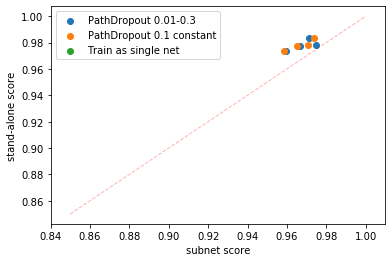

In [86]:
plt.scatter(scores_3, ref, label='PathDropout 0.01-0.3')
plt.scatter(scores_2, ref, label='PathDropout 0.1 constant')
plt.scatter(scores_1, ref, label='Train as single net')
plt.plot([0.85,1],[0.85,1], lw=1, alpha=0.3, ls='--', c='r')
plt.xlabel('subnet score')
plt.ylabel('stand-alone score')
plt.legend()
plt.xlim((0.84,1.01));

Синие и оранжевык точки - с применением dropout, а зеленые - без (их здесь не видно, см. ниже).

Суперсеть, обученная без dropout, не может предсказывать поведение тех же сеток, но обученных "stand-alone", так же хорошо, как с dropout. Объеснение этому хорошо дано в той статье про One-Shot-суперсеть, и мы сейчас вновь подтвердили это.

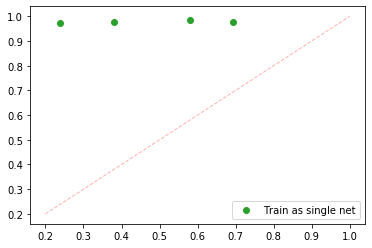

In [91]:
plt.plot([0.2,1],[0.2,1], lw=1, alpha=0.3, ls='--', c='r')
plt.scatter(scores_1, ref, label='Train as single net', c='C2')
plt.legend()

Хоть и на графике кажется, что зеленые точки никак не коррелируют с stand-alone, на самом деле при нормировке значений, корреляция будет видна.

Проверим коррелирование каждого результата с референсом:

In [89]:
np.corrcoef(np.stack([scores_1, scores_2, scores_3, ref]))[3]

array([0.66869493, 0.91665505, 0.69733981, 1.        ])

она у всех > 0.6, а у второго метода самая большая (0.91).

Вот скоры этого метода для каждой подсети:

In [92]:
scores_oneshot_2

{((0,), (0,)): (0.08939035969786346, 0.9740000000000003),
 ((0,), (1,)): (0.14887817274779083, 0.9583000000000002),
 ((1,), (0,)): (0.09292864842340348, 0.9709000000000001),
 ((1,), (1,)): (0.13144653026014563, 0.9653)}

Значит самая лучшая подсеть, по второму эксперименту, это подсеть с двумя Conv(3x3):

In [93]:
supernet.detach_subnet(((0,),(0,)))

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten()
  (5): Linear(in_features=3136, out_features=32, bias=True)
  (6): ReLU()
  (7): Linear(in_features=32, out_features=10, bias=True)
)

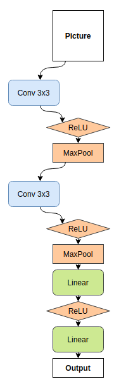

Однако, по всем экспериментам выделяется еще одна, которая имеет сравнимаое качество с предыдущей. Вот она:

In [94]:
supernet.detach_subnet(((1,),(0,)))

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten()
  (5): Linear(in_features=3136, out_features=32, bias=True)
  (6): ReLU()
  (7): Linear(in_features=32, out_features=10, bias=True)
)

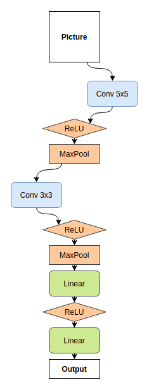

## Big Baby Net (бонус)

Теперь похимичим че-нить интересненькое =)

In [23]:
supernet = SuperNet([
    ChoiceBlockWrapper([
        nn.Conv2d(1, 32, (3,3), padding=1),
        nn.Conv2d(1, 32, (5,5), padding=2),
    ]),
    ChoiceBlockWrapper([
        nn.ReLU(),
        nn.LeakyReLU(),
    ], allow_parallel=False),
    nn.MaxPool2d((2,2), stride=2),
    ChoiceBlockWrapper([
        nn.Conv2d(32, 64, (3,3), padding=1),
        nn.Conv2d(32, 64, (5,5), padding=2),
    ]),
    ChoiceBlockWrapper([
        nn.ReLU(),
        nn.LeakyReLU(),
    ], allow_parallel=False),
    nn.MaxPool2d((2,2), stride=2),
    ChoiceBlockWrapper([
        nn.Conv2d(64, 64, (3,3), padding=1),
        nn.Conv2d(64, 64, (5,5), padding=2),
    ], skip_chance=0.1),
    ChoiceBlockWrapper([
        nn.ReLU(),
        nn.LeakyReLU(),
    ], allow_parallel=False),
    nn.Flatten(),
    nn.Linear(7*7*64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
]).to(device)

Сначала я добавил Tanh, как дополнительная активация на попробовать, но это даже не сходилось, поэтому обойдемся схожими по смыслу ReLU и LeakyReLU. Это вполне логично, что разные виды активации не уживаются вметсе, думаю, понятно почему.

In [37]:
len(supernet.get_all_choices())

288

Сейчас в этом малыше уже существует 288 разных комбинаций подсеток. На самом деле это не много для NAS. Посмотрим как оно обучится.

In [24]:
controller = ThompsonSamplingController(supernet)

In [25]:
history = train(20, train_loader, supernet, controller=controller, gamma_start=0.01, gamma_end=0.1, lr=1e-3, prefix_name='big_baby_net2')

 1 / 20, loss = 0.4046, val_loss = 0.1616


e:\program files win2\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ThompsonSamplingController. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
e:\program files win2\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SuperNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
e:\program files win2\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ChoiceBlockWrapper. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 2 / 20, loss = 0.1499, val_loss = 0.1102


 3 / 20, loss = 0.1084, val_loss = 0.1270


 4 / 20, loss = 0.0879, val_loss = 0.0934


 5 / 20, loss = 0.0754, val_loss = 0.0804


 6 / 20, loss = 0.0681, val_loss = 0.0825


 7 / 20, loss = 0.0611, val_loss = 0.0748


 8 / 20, loss = 0.0569, val_loss = 0.0677


 9 / 20, loss = 0.0543, val_loss = 0.0713


10 / 20, loss = 0.0505, val_loss = 0.0614


11 / 20, loss = 0.0460, val_loss = 0.0617


12 / 20, loss = 0.0450, val_loss = 0.0569


13 / 20, loss = 0.0442, val_loss = 0.0623


14 / 20, loss = 0.0430, val_loss = 0.0595


15 / 20, loss = 0.0392, val_loss = 0.0638


16 / 20, loss = 0.0373, val_loss = 0.0624


17 / 20, loss = 0.0358, val_loss = 0.0642


18 / 20, loss = 0.0367, val_loss = 0.0688


19 / 20, loss = 0.0348, val_loss = 0.0680


20 / 20, loss = 0.0360, val_loss = 0.0647


In [14]:
# loaded = torch.load('big_baby_net_last.pt')
# supernet.load_state_dict(loaded['model'])
# controller = loaded['controller']

Покажем 10 лучших подсеток:

In [26]:
controller.get_top_k_choices(10, 1000)

[[((0,), (0,), (1,), (1,), (1,), (1,)), 0.02606532366113051],
 [((1,), (1,), (1,), (0,), (1,), (0,)), 0.02619634288069057],
 [((1,), (0,), (1,), (0,), (1,), (0,)), 0.032641945224579264],
 [((1,), (1,), (1,), (1,), (0, 1), (0,)), 0.03289441538583018],
 [((1,), (0,), (0, 1), (1,), (1,), (0,)), 0.03295718668034299],
 [((1,), (1,), (0, 1), (1,), (1,), (1,)), 0.03590003162400646],
 [((0, 1), (0,), (1,), (0,), (1,), (1,)), 0.036811469589487056],
 [((0, 1), (1,), (1,), (0,), (1,), (1,)), 0.037160280158632764],
 [((1,), (0,), (1,), (0,), (1,), (1,)), 0.037677226169034836],
 [((1,), (1,), (1,), (1,), (1,), (1,)), 0.03826796087607937]]

А вот она, самая красавица из всех:

In [30]:
best_subnet = supernet.detach_subnet(((0,), (0,), (1,), (1,), (1,), (1,)))
best_subnet

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): LeakyReLU(negative_slope=0.01)
  (8): Flatten()
  (9): Linear(in_features=3136, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

Здест у нас:
- Conv(3x3)+ReLU,
- Conv(5x5)+LeakyReLU,
- Conv(5x5)+LeakyReLU,

Интересный выбор! В своем первоночальном виде, только что оторванном от СуперНета, она дает уже неплохой результат:

In [29]:
evaluate(best_subnet)  # before

(0.060136584336578376, 0.9837000000000002)

Доучим еще 3 эпохи:

In [31]:
train(3, train_loader, best_subnet, lr=1e-4, prefix_name='best_subnet')

 1 /  3, loss = 0.0156, val_loss = 0.0397


 2 /  3, loss = 0.0083, val_loss = 0.0347


 3 /  3, loss = 0.0068, val_loss = 0.0366


[[0.015598393040803791, 0.03965930739184841],
 [0.008259111839193803, 0.03468220624141395],
 [0.006818551068735361, 0.03660611256491393]]

In [39]:
evaluate(best_subnet)  # after

(0.03216737349815958, 0.9909000000000003)

99%, Неплохо! (Хотя для MNIST это обычный скор)

Но зато, мы обучили за раз 288 сеток за 20 эпох, потом выбрали лучшую подсетку исходя из лоссов на трэин и "трэин-субвалидационной" дате, затем доучили эту лучшую подсеть еще 3 эпохи, и получили 99% accuracy на отложенной val дате!

## Further experimetns

В реализованном методе SuperNet есть большой потенциал. Вот что бы я добавил, если бы было еще время:

- Поддержку **Residual-Connections** (легко достигнуть простым пробросом второго инпута в каждый ChoiceBlock)
- Поддержку для разных **filter_sizes** в одном блоке (делается с помощью conv(1x1), который выравнивал бы filter_size у всех подблоков)
- Можно использовать **MaxPool'ы** и Conv с **четными кернелами**, если добавить AdaptiveAvgPool2d (как и было предложено в статье)
- **И наконец**, очень крутая штука, которую я добалю, даже просто для себя, чтобы посмотреть как это сработает - **ThompsonSampling**. С ним мы будем обучать, не просто рандомно сэмплируя пути с PathDropout, а использовать простую, но "умную" стратегию сэмплирования, взятую из RL. Таким образом мы сможем запоминать, какие пути давали более хороший скор, а какие менее. Мы будем сэмплировать более хорошие пути, чтобы сравнивать хорошие с хорошими, и таким образом, определить лучший. То есть, этот метод позволит гораздо быстрее перебрать все хорошие вариации, набрать для них статистику, и выбрать из них самую лучшую. Это должно быть точно лучше чем рандом! (Правда не факт, что это будет хорошо работать с огромными моделями, но наверняка, этот метод можно оптимизировать и под этот случай)